In [11]:
%matplotlib inline

import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

print(f"Using Cantera version {ct.__version__}")

Using Cantera version 2.6.0


# Parallelized reactor simulations

In this example, we will see how to use Python's [`multiprocessing` module](https://docs.python.org/3/library/multiprocessing.html), which uses subprocesses to run concurrent calculations. In other words, it can use multiple cores on your local machine to run a set of simulations simultaneously.

Note that while the code snippets are presented here in a Jupyter Notebook, you will need to create `.py` files and run these programs from the command line to run truly parallel processes.
(It may actually be possible to use `multiprocessing` within a Jupyter Notebook with some additional work, at least on Unix systems, but that is a bit more effort than we want to spend here.)

The example problem we will focus on here is to perform a large number of constant-pressure homogeneous ignition delay calculations for an H2-O2 system, at 5 atm and with a stoichiometric mixture in air, but with varying initial temperatures. 

Let's run each case for a maximum of 1 second, but end the simulation when ignition is detected (via a temperature increase of 400 K).

## Initial implementation

Let's start by setting this up using a simple `for` loop to iterate over the different cases.

In [12]:
temperatures = np.linspace(1000, 2000, 15)
pressure = 5 * ct.one_atm

ignition_delays = np.zeros_like(temperatures)
for idx, temp in enumerate(temperatures):
    # set initial conditions
    gas = ct.Solution('gri30.yaml')
    gas.TP = temp, pressure
    gas.set_equivalence_ratio(1.0, fuel='H2', oxidizer={"O2": 1.0, "N2": 3.76})
    
    # create reactor, and the simulation object
    reac = ct.IdealGasConstPressureReactor(gas)
    sim = ct.ReactorNet([reac])
    
    while sim.time < 1.0:
        sim.step()
        
        if reac.T >= temp + 400.0:
            ignition_delays[idx] = sim.time
            break

Now we can plot the resulting ignition delays, using a standard Arrhenius plot (1000 / temperature on the x-axis):

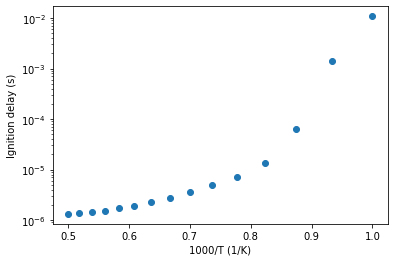

In [13]:
plt.semilogy(1000/temperatures, ignition_delays, 'o')
plt.xlabel('1000/T (1/K)')
plt.ylabel('Ignition delay (s)')
plt.show()

This does not take long at all, since the kinetic model is fairly small and we only have 15 cases.
However, for a much larger number of cases and/or a larger and more complicated model, running these calculations could take a *long* time, and it would be beneficial to use the threads available on your machine to run some in parallel.

## Initial multiprocessing implementation

We can set up the set of simulation jobs to be run by creating a function for running each simulation and  using the `Pool` class provided by `multiprocessing`.

In [14]:
def simulation_worker1(sim_tuple):
    '''Takes job index and initial temperature, runs the simulation, and returns ignition delay.
    '''
    temp, idx = sim_tuple
    pressure = 5 * ct.one_atm
    phi = 1.0
    
    # set initial conditions
    gas = ct.Solution('gri30.yaml')
    gas.TP = temp, pressure
    gas.set_equivalence_ratio(phi, fuel='H2', oxidizer={"O2": 1.0, "N2": 3.76})
    
    # create reactor, and the simulation object
    reac = ct.IdealGasConstPressureReactor(gas)
    sim = ct.ReactorNet([reac])
    
    ignition_delay = 0.0
    while sim.time < 1.0:
        sim.step()
        
        if reac.T >= temp + 400.0:
            ignition_delay = sim.time
            break
    
    return {idx: ignition_delay}

In [15]:
import multiprocessing

# use all the available threads but 1
num_threads = multiprocessing.cpu_count() - 1

In [16]:
print(num_threads)

9


Next, we set up the inputs and create the `Pool` of workers and give them jobs.

**Note!** You should not actually run this in Jupyter Notebook. Create a file, such as `parallel_ignition1.py` and add this to it:

```python
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing

def simulation_worker1(sim_tuple):
    '''Takes job index and initial temperature, runs the simulation, and returns ignition delay.
    '''
    temp, idx = sim_tuple
    pressure = 5 * ct.one_atm
    phi = 1.0
    
    # set initial conditions
    gas = ct.Solution('gri30.yaml')
    gas.TP = temp, pressure
    gas.set_equivalence_ratio(phi, fuel='H2', oxidizer={"O2": 1.0, "N2": 3.76})
    
    # create reactor, and the simulation object
    reac = ct.IdealGasConstPressureReactor(gas)
    sim = ct.ReactorNet([reac])
    
    ignition_delay = 0.0
    while sim.time < 1.0:
        sim.step()
        
        if reac.T >= temp + 400.0:
            ignition_delay = sim.time
            break
    
    return {idx: ignition_delay}

if __name__ == '__main__':
    # use all the available threads but 1
    num_threads = multiprocessing.cpu_count() - 1

    temperatures = np.linspace(1000, 2000, 15)
    ignition_delays = np.zeros_like(temperatures)

    # create list of jobs, each with a tuple of inputs
    simulations = []
    for idx, temp in enumerate(temperatures):
        simulations.append([temp, idx])
    jobs = tuple(simulations)

    # create pool of workers and apply worker function to this
    pool = multiprocessing.Pool(processes=num_threads)
    results = pool.map(simulation_worker1, jobs)
    pool.close()
    pool.join()

    results = {key:val for k in results for key, val in k.items()}
    ignition_delays = np.zeros(len(results))
    for idx, ignition_delay in results.items():
        ignition_delays[idx] = ignition_delay

    plt.semilogy(1000/temperatures, ignition_delays, 'o')
    plt.xlabel('1000/T (1/K)')
    plt.ylabel('Ignition delay (s)')
    plt.show()
```

Then, run this file with:

```
$ python parallel_ignition1.py 
```

You should (quickly) see a plot of the same ignition delay calculations as above. 🎉

## Improved multiprocessing implementation

The initial implementation works, but we can use object-oriented programming concepts to make this cleaner and more generalizable.

First, let's start with a `NamedTuple` to organize inputs:

In [4]:
from typing import NamedTuple, Dict

class Input(NamedTuple):
    """Holds input parameters for a single autoignition case.
    """
    model_file: str
    temperature: float
    pressure: float
    equivalence_ratio: float = 1.0
    fuel: Dict = {}
    oxidizer: Dict = {}
    end_time: float = 1.0

This allows us to create a set of autoignition simulations that can have very different parameters, and even use different kinetic models. However, for now, we'll replicate the same cases.

In [5]:
temperatures = np.linspace(1000, 2000, 15)

pressure = 5 * ct.one_atm

inputs = []
for temp in temperatures:
    inputs.append(Input(
        'gri30.yaml', temp, pressure, 1.0, {'H2': 1.0}, 
        {'O2': 1.0, 'N2': 3.76}, 1.0
        ))

Next, let's create a `Simulation` object with methods that set up and then run the autoignition simulations.

In [8]:
class Simulation(object):
    def __init__(self, properties):
        '''Initialize constant-pressure autoignition simulation.
        '''
        self.gas = ct.Solution(properties.model_file)
        self.gas.TP = properties.temperature, properties.pressure
        self.gas.set_equivalence_ratio(
            properties.equivalence_ratio, properties.fuel, properties.oxidizer
            )
        
        self.reac = ct.IdealGasConstPressureReactor(self.gas)
        self.sim = ct.ReactorNet([self.reac])
        
        self.initial_temperature = properties.temperature
        self.ignition_delay = 0.0
        self.end_time = properties.end_time
    
    def run_case(self):
        '''Runs autoignition simulation.
        '''
        while self.sim.time < 1.0:
            self.sim.step()

            if self.reac.T >= self.initial_temperature + 400.0:
                self.ignition_delay = self.sim.time
                break

Our simulation worker function then needs to be revised to use this class:

In [17]:
def simulation_worker2(inp_tuple):
    '''Takes job index and inputs, runs simulation, returns ignition delay.
    '''
    idx, inputs = inp_tuple
    sim = Simulation(inputs)
    sim.run_case()
    
    return {idx: sim.ignition_delay}

Then, our main driver code needs to be updated accordingly:

```python
num_threads = multiprocessing.cpu_count() - 1

temperatures = np.linspace(1000, 2000, 15)

pressure = 5 * ct.one_atm

# create list of jobs, each with a tuple of inputs
inputs = []
for idx, temp in enumerate(temperatures):
    inputs.append([idx, Input(
        'gri30.yaml', temp, pressure, 1.0, {'H2': 1.0}, 
        {'O2': 1.0, 'N2': 3.76}, 1.0
        )])
jobs = tuple(inputs)

# create pool of workers and apply worker function to this
pool = multiprocessing.Pool(processes=num_threads)
results = pool.map(simulation_worker2, jobs)
pool.close()
pool.join()

results = {key:val for k in results for key, val in k.items()}
ignition_delays = np.zeros(len(results))
for idx, ignition_delay in results.items():
    ignition_delays[idx] = ignition_delay

plt.semilogy(1000/temperatures, ignition_delays, 'o')
plt.xlabel('1000/T (1/K)')
plt.ylabel('Ignition delay (s)')
plt.show()
```